# Examen Práctico 

#### 01-3900 | Ciencia de datos | 2024

Alumno: Meza, Julian

## Enunciado

Se tienen un dataset con datos de pacientes internados en un hospital (TP_Virus_Alumnos.csv). La clase de interes (1) refiere a la presencia de un virus. El virus tiene normalmente una gravedad leve/baja y el tratamiento suele ser invasivo. Datos como nombre y apellido han sido eliminados y los valores tanto en sangre (BLD), hormonales u otros análisis sobre reactivos han sido alterados en sus valores para preservar la privacidad. Se aclara que no se ha modificado su capacidad predictiva (Si es que la tienen).


Para su conocimiento: </BR>
Datos generales de Edad, Peso, Altura y condición laboral (Activo, Pasivo etc).
Datos medidos en hospital:</BR>
BLD: Sangre</BR>
LVL: Hormonales</BR>
REC: Otros análisis</BR>

Se pide obtener con los datos disponibles el mejor modelo posible que prediga la presencia o ausencia del virus. 
Dado que el tratamiento es invasivo y la grevedad es moderada se requiere "atrapar" tantos "1" como sea posible y minimizar los falsos positivos para evitar que reciban un tratamiento de estas caracteristicas personas que no presentan el virus. Intente obtener el mejor modelo que maximice la métrica que considere correspondiente.



## Como desarrollar el exámen

A partir del dataset realice todas las acciones para poder llegar al mejor modelo, explique brevemente en los fundamentos de sus transformaciones o acciones en general. 

La nota derivará de: </BR>
1.La calidad de la clasificación realizada</BR>
2.La fundamentación de los pasos realizados</BR>
3.Lo sencillo de llevar a producción el desarrollo</BR> 



Los docentes evaluaran su clasificador utilizando un conjunto de datos del dataset "fuera de la caja" (out of the box, al que usted no tiene acceso). Para minimizar la posible diferencia entre su medición y la medición del docente recuerde y aplique conceptos de test, validación cruzada y evite los errores comunes de sesgo de selección y fuga de datos (PPT/Pdf Árboles de clasificación) o  Sklearn "10. Common pitfalls and recommended practices" disponible en "https://scikit-learn.org/stable/common_pitfalls.html"   

Al final del notebook encontrará un bloque de código que lee la muestra adicional (a la que usted no tiene acceso) si PRODUCCION==True, en caso contrario solo lee una submuestra del conjunto original para validar que el código funciona. Desarrolle el notebook como considere, para finalmente asignar el mejor clasificador que usted haya obtenido remplazando en f_clf = None, None por su clasificador. Implemente todas las transformaciones entre esa línea y la predición final (Evitando al fuga de datos). Ver TP_AutomatizarTransformaciones.ipynb

En materiales del MIEL se adjunta un notebook que propone algunas ideas para automatizar el proceso.

# Desarrollo

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

### Modelo de Entrenamiento

In [2]:
class Models:
    def __init__(self) -> None:
        pass

    def gaussian(self) -> GaussianNB:
        return GaussianNB()

    def decission_tree_classfier(self, max_depth = 7, random_state = 0) -> DecisionTreeClassifier:
        return DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)

    def logistic_regression(self) -> LogisticRegression:
        return LogisticRegression(
            C=0.1,
            class_weight='balanced',
            fit_intercept=True,
            l1_ratio=0.5,
            max_iter=100,
            penalty='l1',
            solver='saga',
            tol=0.0001,
            random_state=0
        )

## Análisis Exploratorio

In [3]:
df_virus = pd.read_csv("TP_Virus_Alumnos.csv")
df_virus.head(15)

,Edad,Genero,Peso,Laboral,hijos,BLD01,REC1,REC2,REC3,REC4,REC5,BLD02,BLD03,LVL,target
0,9.0,Femenino,36.410602,Inactivo,0,3.139714,6.929112,63.712640,73.880613,15.087239,90.400193,2.015331,1.633836,51.411632,0
1,58.0,Masculino,115.507184,Inactivo,4,2.953914,4.660136,64.582610,73.669319,14.503106,90.817947,0.973317,-0.439358,1000000.000000,0
2,74.0,Masculino,81.249035,Activo,3,1.365200,3.005861,63.613454,75.103984,14.077988,91.741638,3.243344,0.380413,1000000.000000,1
3,NaN,Masculino,77.985589,No_declara,0,2.329285,4.344642,64.433115,73.402436,15.583846,91.741709,3.188290,-0.226046,NaN,0
4,1.0,Femenino,13.446208,Inactivo,0,-0.062975,3.938741,65.122602,75.007982,16.961593,90.668625,2.729202,0.589698,21.627303,1
5,39.0,Masculino,100.752944,Activo,4,0.574689,3.868364,63.126609,73.410501,15.789951,89.211917,1.169552,1.099371,115.070380,0
6,77.0,Masculino,81.238369,Inactivo,4,1.531349,4.318537,63.513104,71.025204,14.779903,89.160829,2.034808,1.116236,1000000.000000,1
7,48.0,Masculino,108.241968,No_declara,1,3.192311,4.072476,63.834061,73.652055,16.787495,92.143975,1.745791,1.386591,104.976352,0
8,63.0,NaN,81.907770,Activo,4,1.185980,3.799356,63.638205,75.423896,14.515515,88.874644,1.662188,0.514841,119.076322,1
9,29.0,NaN,82.157068,Activo,0,2.464750,5.324854,63.820457,72.639370,15.890319,90.383575,0.639324,-0.841893,1000000.000000,1


In [4]:
df_virus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Edad     3378 non-null   float64
 1   Genero   2518 non-null   object 
 2   Peso     4200 non-null   float64
 3   Laboral  4200 non-null   object 
 4   hijos    4200 non-null   int64  
 5   BLD01    4200 non-null   float64
 6   REC1     4200 non-null   float64
 7   REC2     4200 non-null   float64
 8   REC3     4200 non-null   float64
 9   REC4     4200 non-null   float64
 10  REC5     4200 non-null   float64
 11  BLD02    4200 non-null   float64
 12  BLD03    4200 non-null   float64
 13  LVL      3673 non-null   float64
 14  target   4200 non-null   int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 492.3+ KB


In [5]:
df_virus.describe(include='all')

,Edad,Genero,Peso,Laboral,hijos,BLD01,REC1,REC2,REC3,REC4,REC5,BLD02,BLD03,LVL,target
count,3378.000000,2518,4200.000000,4200,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,3673.000000,4200.000000
unique,NaN,3,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Masculino,NaN,Inactivo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,2159,NaN,2088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,38.658082,NaN,74.011575,NaN,1.817619,1.490120,4.016418,64.022288,73.014364,15.016203,90.002233,1.341927,0.581248,227134.359847,0.406429
std,25.048819,NaN,25.792979,NaN,1.684604,1.161904,0.998691,1.001091,1.033638,1.038452,1.016661,1.013156,0.995871,418951.218478,0.491225
min,0.000000,NaN,8.934178,NaN,0.000000,-2.994895,0.205533,60.891330,69.169010,10.522455,86.498273,-3.081166,-3.627277,-15.793610,0.000000
25%,15.000000,NaN,59.380536,NaN,0.000000,0.737673,3.327644,63.342178,72.327535,14.307355,89.318117,0.723712,-0.028103,85.325898,0.000000
50%,38.000000,NaN,81.736000,NaN,2.000000,1.483044,4.011945,64.008366,73.009128,15.018368,89.997148,1.391925,0.554453,108.636906,0.000000
75%,63.000000,NaN,92.850926,NaN,3.000000,2.234045,4.693314,64.702143,73.688073,15.711698,90.679398,2.030700,1.226230,137.010754,1.000000


In [6]:
# Verificamos si hay valores nulos para imputar
df_virus.isnull().sum()

Edad        822
Genero     1682
Peso          0
Laboral       0
hijos         0
BLD01         0
REC1          0
REC2          0
REC3          0
REC4          0
REC5          0
BLD02         0
BLD03         0
LVL         527
target        0
dtype: int64

In [7]:
print(df_virus['Genero'].unique())
print(df_virus['Laboral'].unique())

['Femenino' 'Masculino' nan 'Otro']
['Inactivo' 'Activo' 'No_declara']


##### Análisis Exploratorio de Datos (EDA)
Información General:
* Número de entradas: 4200
* Columnas: 15
* Tipos de datos: 11 columnas son de tipo float64, 2 son de tipo int64, y 2 son de tipo object.
Columnas con valores faltantes:
* Edad: 3378 valores no nulos.
* Genero: 2518 valores no nulos.
* LVL: 3673 valores no nulos.

##### Manejo de valores faltantes:
* Imputación de valores faltantes para Edad, Genero, y LVL.
##### Análisis y codificación de variables categóricas:
* Convertir la variable Genero a una representación numérica.
* Convertir la variable Laboral a una representación numérica.

### Análisis de la variable target

La variable target está BALANCEADA.
target
0    2493
1    1707
Name: count, dtype: int64


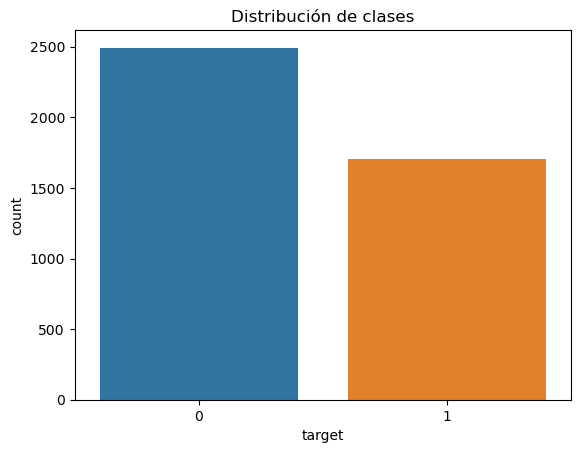

In [8]:
def check_target_balance(df_virus):
    """
    Contar las ocurrencias de cada clase en la variable target, calcular la proporción de cada clase
    y determinar si la variable target está balanceada o desbalanceada.

    Args:
        df_virus (DataFrame): DataFrame que contiene la columna 'target' con las clases.

    Returns:
        None: Imprime la distribución de clases y un mensaje indicando si la variable target está balanceada o no.
    """
    # Contar las ocurrencias de cada clase en la variable target
    target_counts = df_virus["target"].value_counts()

    # Calcular la proporción de cada clase
    target_counts_proportion = target_counts / target_counts.sum()

    # Determinar si la variable target está desbalanceada
    if target_counts_proportion[1] > 0.8 or target_counts_proportion[0] > 0.8:
        print("La variable target está DESBALANCEADA.")
    else:
        print("La variable target está BALANCEADA.")

    # Mostrar los resultados
    print(target_counts)
    sns.countplot(data=df_virus, x="target", hue="target", legend=False).set_title(
        "Distribución de clases"
    )

check_target_balance(df_virus)

Viendo los resultados de balancio obtenidos, y condiderando la cantidad de la muestra se púede dar una primera conclusion que no es necesario proceder con alguna tecnica de balanceo u aplicar, bajo este contexto, una tecnica de **Validación Cruzada** de forma mandatoria.

## Análisis y tratamiento de outliers y datos faltantes

In [9]:
class Outliers:
    """
    Clase para manejar outliers en un DataFrame.

    Atributos:
        df (pd.DataFrame): DataFrame que contiene los datos.
        column_name (str): Nombre de la columna donde se buscarán outliers.
        outliers (pd.DataFrame): DataFrame que contiene los outliers detectados.

    Métodos:
        calculate(): Calcula los outliers en la columna especificada utilizando el rango intercuartílico (IQR).
        replace_with(value: float): Reemplaza los outliers en la columna con un valor específico.
        replace_with_mean(): Reemplaza los outliers en la columna con la media de la columna.
        outliers_length(): Devuelve la cantidad de outliers detectados.
    """
    def __init__(self, df: pd.DataFrame, column_name: str):
        self.df = df
        self.column_name = column_name
        self.outliers = self.calculate()

    def calculate(self):
        Q1 = self.df[self.column_name].quantile(0.25)
        Q3 = self.df[self.column_name].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        return self.df[(self.df[self.column_name] < lower_bound) | (self.df[self.column_name] > upper_bound)]

    def replace_with(self, value: float):
        self.df.loc[self.outliers.index, self.column_name] = value

    def replace_with_mean(self):
        self.replace_with(self.df[self.column_name].mean())

    def outliers_length(self):
        return len(self.outliers)

In [10]:
def resolve_outliers(column_name: str, df: pd.DataFrame):
    outliers = Outliers(df, column_name)
    print("La cantidad de outliers con " + column_name + " son: " + str(outliers.outliers_length()))
    df[column_name].plot(kind='hist', alpha=0.7, legend=True)

La cantidad de outliers con BLD01 son: 56
La cantidad de outliers con BLD02 son: 55
La cantidad de outliers con BLD03 son: 68


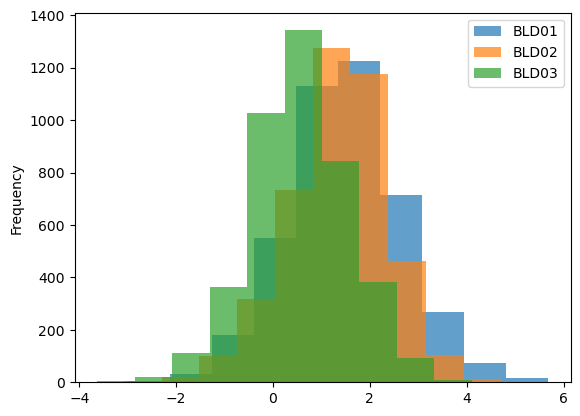

In [11]:
#df_virus.columns
for col in ['BLD01', 'BLD02', 'BLD03']:
    resolve_outliers(col, df_virus)

La cantidad de outliers con REC1 son: 26
La cantidad de outliers con REC2 son: 23
La cantidad de outliers con REC3 son: 40
La cantidad de outliers con REC4 son: 30
La cantidad de outliers con REC5 son: 27


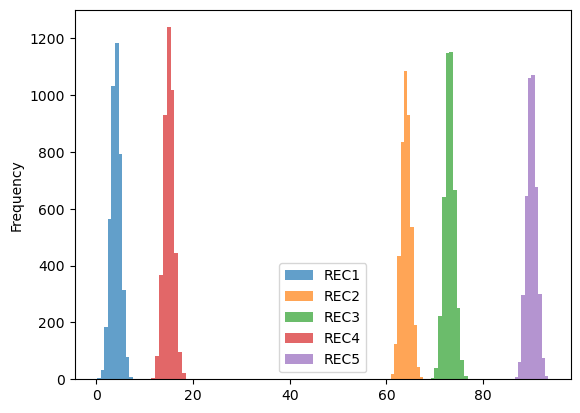

In [12]:
for col in [ 'REC1', 'REC2',
       'REC3', 'REC4', 'REC5']:
    resolve_outliers(col, df_virus)

## Correlación de Variables

C:\Users\julian\AppData\Local\Temp\ipykernel_2640\2521890294.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_variable_correlation["Genero"] = df_variable_correlation["Genero"].replace(
C:\Users\julian\AppData\Local\Temp\ipykernel_2640\2521890294.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_variable_correlation["Laboral"] = df_variable_correlation["Laboral"].replace(


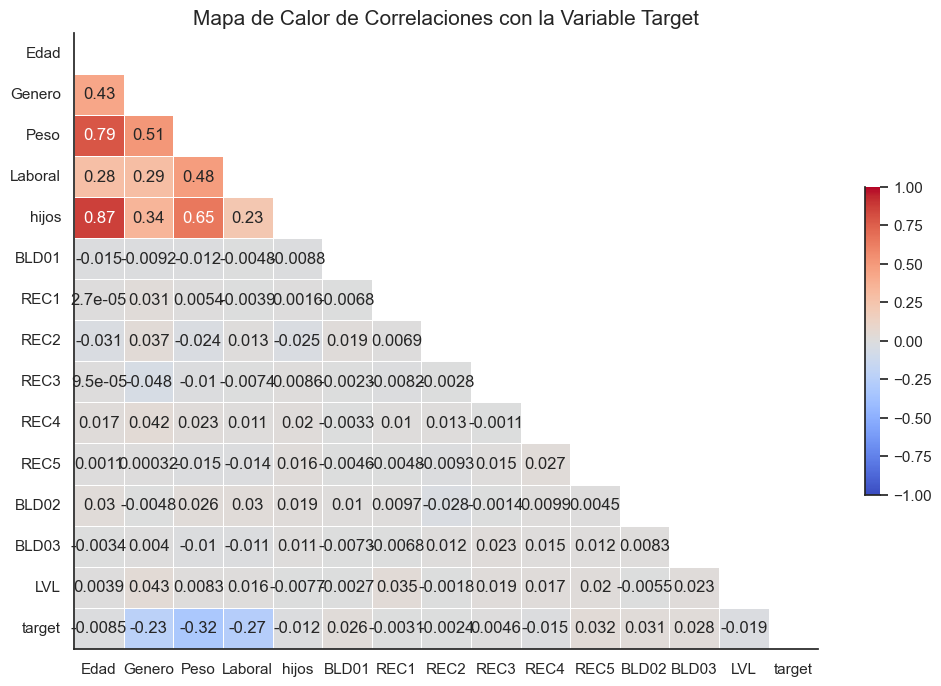

In [13]:
df_variable_correlation = df_virus.copy()
df_variable_correlation["Genero"] = df_variable_correlation["Genero"].replace(
    {"Femenino": 0, "Masculino": 1, "Otro": 2}
)
df_variable_correlation["Laboral"] = df_variable_correlation["Laboral"].replace(
    {"Inactivo": 0, "Activo": 1, "No_declara": 2}
)
df_variable_correlation.head(10)
# Calcular la matriz de correlación
correlation_matrix = df_variable_correlation.corr()

# Configuración de la figura y el estilo
sns.set(style="white", rc={"figure.figsize": (12, 8)})

# Máscara para la parte superior del heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Crear el heatmap
heatmap = sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

# Ajustes adicionales
heatmap.set_title("Mapa de Calor de Correlaciones con la Variable Target", size=15)

# Mostrar gráfico
sns.despine()

Para visualizar el gráfico correctamente, es necesario transformar los valores de tipo string en valores numéricos (float) para que puedan ser procesados adecuadamente por las funciones de visualización.

Observando el grafico se aprecia que las variables `Peso`, `Edad` e `hijos` son las que mayor correlacin tienen. Pero al preceder a quitarlas el Score del modelo empeora. 


<hr>

### Separación de conjunto de datos

In [14]:
x_target = df_virus.drop('target', axis=1)
y_target = df_virus['target']

X_train, X_test, y_train, y_test = train_test_split(x_target, y_target, random_state=27, test_size=0.2)

## Pipeline

### StringConvert

In [15]:
class StringConvert(BaseEstimator, TransformerMixin):
    def __init__(self, columns: list[str], replace_objects: list[any]):
        super().__init__()
        if len(columns) != len(replace_objects):
            raise ValueError(
                "La cantidad de columnas no coinciden con la cantidad de replaced_objects"
            )
        self.columns = columns
        self.replace_objects = replace_objects

    def fit(self, x: pd.DataFrame, y=None):
        return self

    def get_feature_names_out(self):
        return self.columns

    def transform(self, x: pd.DataFrame):
        for idx, column_name in enumerate(self.columns):
            x[column_name] = x[column_name].replace(self.replace_objects[idx])
        return x

### ColOneHot

In [16]:
class ColOneHot(BaseEstimator, TransformerMixin):
    def __init__(
            self,
            columns: list[str],
            encoder=OneHotEncoder(sparse=False, drop='first', dtype=int)
    ):
        super().__init__()
        self.encoder = encoder
        self.columns = columns

    def fit(self, x: pd.DataFrame, y=None):
        self.encoder.fit(x[self.columns])
        return self

    def get_feature_names_out(self):
        return self.encoder.get_feature_names_out(self.columns)

    def  transform(self, x: pd.DataFrame):
        X_copy = x.copy()
        transformed = self.encoder.transform(X_copy[self.columns])

        transformed_df = pd.DataFrame(
            transformed,
            index=X_copy.index,
            columns=self.get_feature_names_out()
        )

        # Eliminar las columnas originales
        X_copy.drop(columns=self.columns, inplace=True)

        # Concatenar el DataFrame transformado con el DataFrame original
        X_copy = pd.concat([X_copy, transformed_df], axis=1)

        return X_copy

### DropVariables

In [17]:
class DropVariables(BaseEstimator, TransformerMixin):
    def __init__(self, columns: list[str]):
        super().__init__()
        self.columns = columns

    def fit(self, x: pd.DataFrame, y=None):
        return self

    def get_feature_names_out(self):
        return self.columns

    def  transform(self, x: pd.DataFrame):
        for column_name in self.columns:
            x = x.drop(column_name, axis=1)
        return x

### Imputadores

#### Imputador simple

In [18]:
class ColSimpleImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns: list[str], imputer=SimpleImputer(strategy='mean')):
        super().__init__()
        self.imputer = imputer
        self.columns = columns

    def fit(self, x: pd.DataFrame, y=None):
        self.imputer.fit(x[self.columns])
        return self

    def get_feature_names_out(self):
        return self.imputer.get_feature_names_out()

    def  transform(self, x: pd.DataFrame):
        x_copy = x.copy()
        x_copy.loc[:, self.columns] = self.imputer.transform(x_copy[self.columns])
        return x_copy

#### Imputador complejo

In [19]:
import numpy as np

class ColComplexImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns: list[str]):
        super().__init__()
        self.columns = columns

    def fit(self, x: pd.DataFrame, y=None):
        return self

    def get_feature_names_out(self):
        return self.columns

    def  transform(self, x: pd.DataFrame):
        for column_name in self.columns:
            df_cleaned = x.dropna(subset=[column_name])

            X_target = df_cleaned.drop(column_name, axis=1)
            Y_target = df_cleaned[column_name]

            models = Models()
            model = models.decission_tree_classfier()

            model.fit(X_target, Y_target)

            X_test = x[x[column_name].isna()]
            X_test = X_test.drop(column_name, axis=1)
            y_pred = model.predict(X_test)

            for idx, row in x.iterrows():
                i = 0
                if np.isnan(row[column_name]):
                    x.loc[idx, column_name] = y_pred[i]
                    i += 1
        return x

### Col StandarScaler

In [20]:
class ColStandarScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns: list[str], scaler=StandardScaler()):
        self.scaler = scaler
        self.columns = columns

    def fit(self, x: pd.DataFrame, y=None):
        self.scaler.fit(x[self.columns])
        return self

    def get_feature_names_out(self):
        return None

    def transform(self, x: pd.DataFrame):
        x_copy = x.copy()
        x_copy[self.columns] = self.scaler.transform(x_copy[self.columns])
        return x_copy

### Desarrollo de Pipeline

In [21]:
models = Models()
pipeline = Pipeline(
    steps=[
        (
            "StringConvert",
            StringConvert(
                columns=["Genero", "Laboral"],
                replace_objects=[
                    {"Femenino": 0, "Masculino": 1, "Otro": 2},
                    {"Inactivo": 0, "Activo": 1, "No_declara": 2},
                ],
            ),
        ),
        ("SimpleImputador", ColSimpleImputer(columns=["Edad", "LVL"])),
        ("ComplexImputador", ColComplexImputer(columns=["Genero"])),
        (
            "StandardScaler",
            ColStandarScaler(
                columns=[
                    "BLD01",
                    "BLD02",
                    "BLD03",
                    "REC1",
                    "REC2",
                    "REC3",
                    "REC4",
                    "REC5",
                ]
            ),
        ),
        ("classifier", models.decission_tree_classfier()),
    ]
)
pipeline.fit(X_train, y_train)

C:\Users\julian\AppData\Local\Temp\ipykernel_2640\4257120900.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x[column_name] = x[column_name].replace(self.replace_objects[idx])


Pipeline(steps=[('StringConvert',
                 StringConvert(columns=['Genero', 'Laboral'],
                               replace_objects=[{'Femenino': 0, 'Masculino': 1,
                                                 'Otro': 2},
                                                {'Activo': 1, 'Inactivo': 0,
                                                 'No_declara': 2}])),
                ('SimpleImputador', ColSimpleImputer(columns=['Edad', 'LVL'])),
                ('ComplexImputador', ColComplexImputer(columns=['Genero'])),
                ('StandardScaler',
                 ColStandarScaler(columns=['BLD01', 'BLD02', 'BLD03', 'REC1',
                                           'REC2', 'REC3', 'REC4', 'REC5'])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=7, random_state=0))])

Exactitud (accuracy) del modelo: 77.62 %


C:\Users\julian\AppData\Local\Temp\ipykernel_2640\4257120900.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x[column_name] = x[column_name].replace(self.replace_objects[idx])


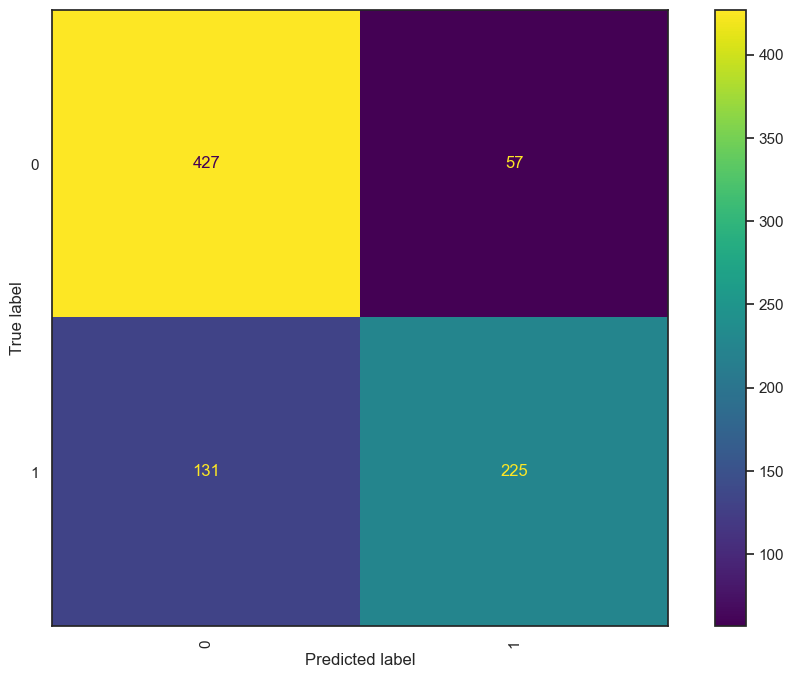

In [22]:
pipeline_pred = pipeline.predict(X_test)
print(
    "Exactitud (accuracy) del modelo: {:.2f} %".format(
        accuracy_score(y_test, pipeline_pred) * 100
    )
)

ConfusionMatrixDisplay.from_estimator(
    pipeline, X_test, y_test, xticks_rotation="vertical"
)

<hr>

## Entrenamos los modelos

## GridSearchCV

#### La clase GridSearchModels se ha diseñado para facilitar la configuración y ejecución de búsquedas exhaustivas de hiperparámetros (GridSearchCV) para varios algoritmos de clasificación (Logistic Regression, Decision Tree, Gaussian Naive Bayes, Random Forest), evaluando múltiples combinaciones de parámetros para encontrar la mejor configuración para cada modelo.

In [23]:
class GridSearchModels:
    def logistic_regression(self):
        parameters = {
            "penalty": ["l1", "l2", "elasticnet"],
            "C": [0.01, 0.1, 1, 10, 100],
            "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
            "max_iter": [100, 200, 500],
            "tol": [1e-4, 1e-5],
            "fit_intercept": [True, False],
            "class_weight": [None, "balanced"],
            "l1_ratio": [0, 0.5, 1],
        }
        return GridSearchCV(LogisticRegression(), parameters, scoring="roc_auc", cv=5)

    def decision_tree_classifier(self, max_depth=None):
        if max_depth is None:
            max_depth = [7, 10, 30, 50, 70, 90, 100]
        parameters = {
            "max_depth": max_depth,
            "min_samples_split": [2, 4],
            "min_samples_leaf": [3, 9],
            "criterion": ["gini", "entropy"],
            "splitter": ["best", "random"],
            "max_features": ["auto", "sqrt", "log2"],
            "max_leaf_nodes": [2, None],
            "min_impurity_decrease": [0.0, 0.5, 1.0, 2.0, 10.0, 20.0, 50.0],
        }
        return GridSearchCV(DecisionTreeClassifier(), parameters, verbose=True, cv=5)

    def gaussian(self):
        parameters = {
            "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
        }
        return GridSearchCV(GaussianNB(), parameters, cv=5, scoring="accuracy")

    def random_forest_classifier(self):
        parameters = {
            "n_estimators": [100, 200, 500, 1000],
            "criterion": ["gini", "entropy"],
            "max_depth": [10, 20, 30, 40, 50, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "max_features": ["auto", "sqrt", "log2"],
            "bootstrap": [True, False],
            "class_weight": [None, "balanced", "balanced_subsample"],
        }
        return GridSearchCV(RandomForestClassifier(), parameters, verbose=True, cv=5)

In [24]:
imputer = SimpleImputer(strategy="mean")  # SimpleImputer con la estrategia de imputación "mean" (media)
X_train_imputed = imputer.fit_transform(X_train)

# Uso de la clase GridSearchModels
gs_models = GridSearchModels()
clf = gs_models.decision_tree_classifier(max_depth=[7, 20])
#clf = gs_models.logistic_regression()
#clf = gs_models.gaussian()
clf.fit(X_train_imputed, y_train)

Fitting 5 folds for each of 1344 candidates, totalling 6720 fits


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Progr

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [7, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [2, None],
                         'min_impurity_decrease': [0.0, 0.5, 1.0, 2.0, 10.0,
                                                   20.0, 50.0],
                         'min_samples_leaf': [3, 9],
                         'min_samples_split': [2, 4],
                         'splitter': ['best', 'random']},
             verbose=True)

#### Resultados del GridSearchCV

In [25]:
print("Best Parameters:", clf.best_params_)
print("Best Score:", clf.best_score_)

Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 9, 'min_samples_split': 4, 'splitter': 'best'}
Best Score: 0.7595238095238095


##### La tecnica de 'decision_tree_classifier' fue la que consiguio mejor Score en comparacion a las demas (Best Score: 0.76)


<hr>

## Evaluacion final - Docente + Alumno

In [26]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

PRODUCCION = False
best_clf = pipeline #Asignar aqui el mejor clasificador posible (previamente entrenado)

# Leemos el dataset de evaluación, simulando producción
if PRODUCCION==False:
    df = pd.read_csv("TP_Virus_Alumnos.csv")
    _, df = train_test_split(df, test_size=0.3, random_state=42)
else:
    df = pd.read_csv("TP_Virus_Evaluacion.csv")

# Dividimos en target y predictoras
X_prod = df.drop("target", axis=1)
y_prod = df["target"]

# Transformaciones


# Evaluación final
y_pred = best_clf.predict(X_prod)
print(classification_report(y_prod, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86       739
           1       0.89      0.64      0.74       521

    accuracy                           0.82      1260
   macro avg       0.84      0.79      0.80      1260
weighted avg       0.83      0.82      0.81      1260



C:\Users\julian\AppData\Local\Temp\ipykernel_2640\4257120900.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x[column_name] = x[column_name].replace(self.replace_objects[idx])


Resultados obtenidos evaluando modelo con dataset de partida

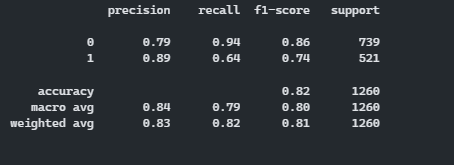

Exactitud (accuracy) del modelo: 81.75 %


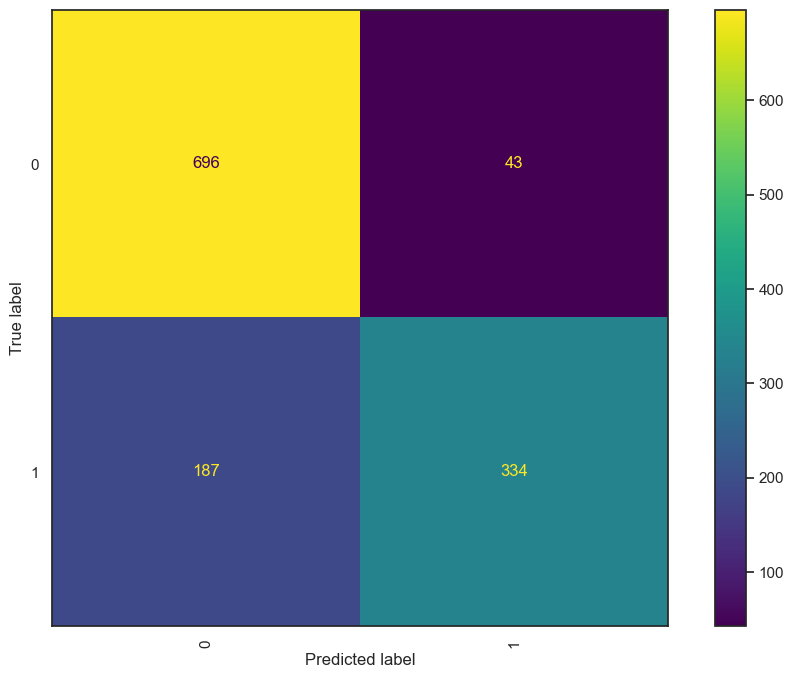

In [27]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

print(
    "Exactitud (accuracy) del modelo: {:.2f} %".format(
        accuracy_score(y_prod, y_pred) * 100
    )
)
ConfusionMatrixDisplay.from_estimator(
    pipeline, X_prod, y_prod, xticks_rotation="vertical"
)